In [29]:
import sys
sys.path.append('..')
from Map import Map

from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import pygrib
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
from datetime import datetime, timedelta
from dateutil import tz

In [30]:
grib_dir = Path('.') / 'data'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [32]:
# Download files
date = 20220706
run = '06'
fhr = '24'
left_lon = 360-90
right_lon = 360-77
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{run}z.conus.prob.f{fhr}.grib2'
              '&all_lev=on&var_APCP=on&subregion='
              f'&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=/href.{date}/ensprod')

def download_gribfilter(file_url):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/href/href.t{run}z.conus.prob.precip.f{fhr}.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [34]:
#%%capture
# Read in files and acquire data needed for plotting
ds = pygrib.open(f'{grib_dir}/href/href.t{run}z.conus.prob.precip.f{fhr}.grib2')

# Reset the grib messages to 0 so you're at beginning of the file
ds.seek(0)

# Get grib message
# For reference, here are the corresponding grib messages with QPF exceedance
#15 = 0.50; 16 = 1.00; 17 = 2.00; 18 = 3.00; 19 = 5.00; 20 = 8.00

for grb in ds:
    print(grb)

ds = ds[24]

# Extract lats, lons, and data values
lats, lons = ds.latlons()
href_values = ds.values

def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

def convert_datetime(pygrib_time: str) -> str:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    
    # Handle weird issue where a valid time of 00Z is in format
    # YYYYMMDD H
    # All other valid times are in format YYYYMMDDHHMM
    if pygrib_time.split(' ')[1] == '0': 
        utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H').replace(tzinfo=from_zone)
    else:
        utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    eastern = roundTime(eastern)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

# Get the date and time of the forecast
dt = str(ds.validityDate) + ' ' + str(ds.validityTime)
VALID_TIME = convert_datetime(dt)

1:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 23-24 hrs (accum):from 202207060600:Probability of event above upper limit (> 12.7)
2:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 23-24 hrs (accum):from 202207060600:Probability of event above upper limit (> 25.4)
3:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 23-24 hrs (accum):from 202207060600:Probability of event above upper limit (> 50.8)
4:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 23-24 hrs (accum):from 202207060600:Probability of event above upper limit (> 76.2)
5:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 21-24 hrs (accum):from 202207060600:Probability of event above upper limit (> 12.7)
6:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 21-24 hrs (accum):from 202207060600:Probability of event above upper limit (> 25.4)
7:Total Precipitation:kg m**-2 (accum):lambert:surface:lev

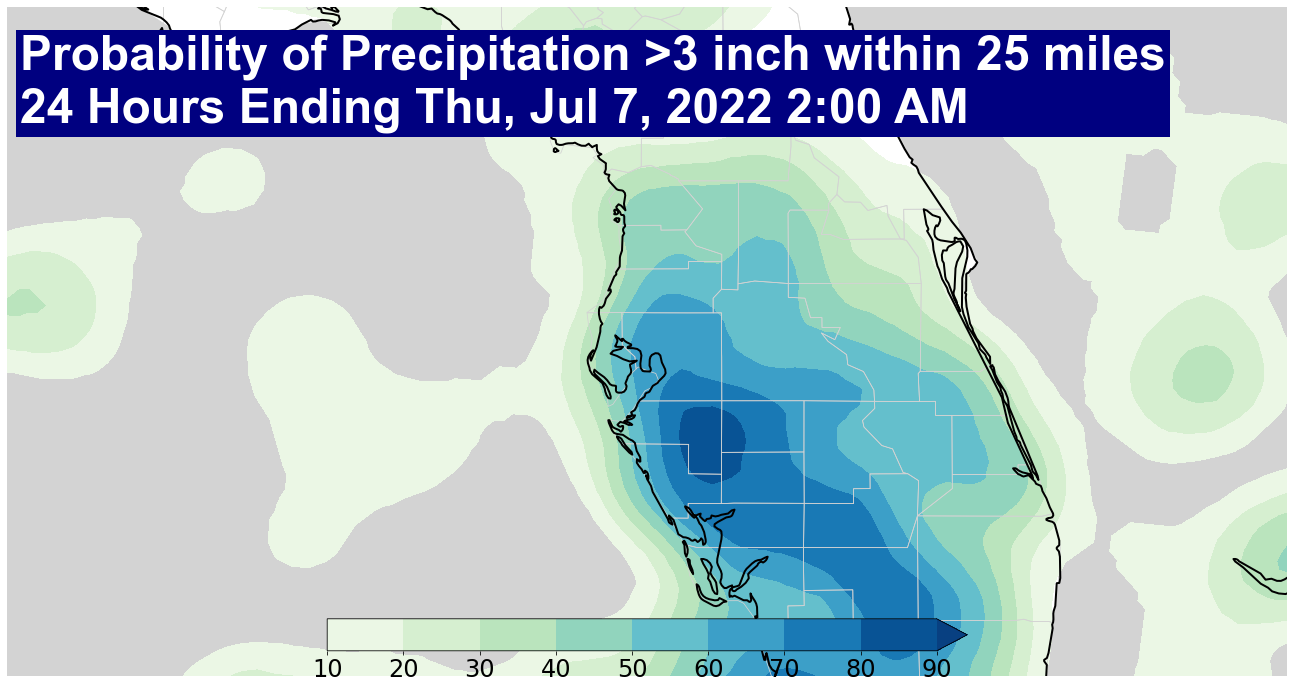

In [35]:
def make_figure():
    new_map = Map('tampa_area')
    new_map.add_counties()
    fig, ax = new_map.make_map()
    return fig, ax

fig, ax = make_figure()

data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.GnBu, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title(f'Probability of Precipitation >3 inch within 25 miles\n24 Hours Ending {VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01, zorder=10,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
plt.savefig(f'{graphics_dir}/precip-3in_{fhr}.png', dpi=72)
plt.show()